In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets
from torchvision.io import read_image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

class SpeakerIdentificationImageDataset(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        classes = pd.read_csv(root + os.sep + "classes.csv")
        annotations_file = root + os.sep + "annotations.csv"
        self.img_labels = pd.read_csv(annotations_file)
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        self.classes = [row["Name"] for index, row in classes.iterrows()]
        self.class_to_idx = {
            row["Name"]: row["Label"] for index, row in classes.iterrows()
        }

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

def count_number_of_parameters(model):
    return sum(p.numel() for p in model.parameters())


In [2]:
DATA_DIR = "/Users/akashganesan/Downloads/16000_pcm_speeches"
IMAGE_SIZE = 32

data_transforms = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
        transforms.ConvertImageDtype(torch.float),
    ]
)

dataset = SpeakerIdentificationImageDataset(DATA_DIR, transform=data_transforms)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
training_data, test_data = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)

Shape of X [N, C, H, W]: torch.Size([1, 3, 32, 32])
Shape of y: torch.Size([1]) torch.int64

X:  tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]])
y:  tensor([0])
Scalar y:  0
label:  Jens_Stoltenberg


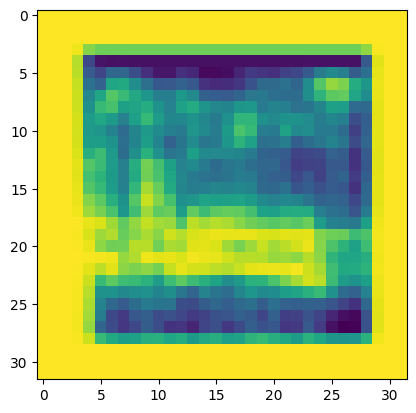

In [3]:
batch_size = 1

# Create data loaders.
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}\n")
    print("X: ", X)
    print("y: ", y)
    print("Scalar y: ", y[0].item())
    break
    
label = dataset.classes[y[0].item()]
print("label: ", label)
imgplot = plt.imshow(X[0][0])

In [4]:
# Get cpu, gpu or mps device for training.

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")


# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(IMAGE_SIZE * IMAGE_SIZE * 3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 5),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)
print(count_number_of_parameters(model))

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=5, bias=True)
  )
)
1838597


In [5]:
dataset.classes

['Jens_Stoltenberg',
 'Benjamin_Netanyau',
 'Julia_Gillard',
 'Magaret_Tarcher',
 'Nelson_Mandela']

In [6]:
model = NeuralNetwork().to(device)
batch_size = 1
test_dataloader = DataLoader(test_data, batch_size=batch_size)

X, y = next(iter(test_dataloader))   
X = X.to(device)
pred = model(X)

pred

tensor([[ 0.0422, -0.0403,  0.0525, -0.0071, -0.0450]],
       grad_fn=<AddmmBackward0>)

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    losses, accuracies = [],[]
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        # Nudge
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            accuracy = (torch.sum((torch.argmax(pred, dim=1) == y).type(torch.float))/len(y)).item()
            losses.append(loss)
            accuracies.append(accuracy)
    return losses, accuracies

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:

batch_size = 16

model = NeuralNetwork().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

epochs = 5
train_losses, train_accuracies = [], []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    losses, accuracies = train(train_dataloader, model, loss_fn, optimizer)
    train_losses.extend(losses)
    train_accuracies.extend(accuracies)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.620036  [   16/ 6750]
loss: 1.098780  [ 1616/ 6750]
loss: 0.676255  [ 3216/ 6750]
loss: 0.441727  [ 4816/ 6750]
loss: 0.289755  [ 6416/ 6750]
Test Error: 
 Accuracy: 87.9%, Avg loss: 0.355940 

Epoch 2
-------------------------------
loss: 0.326298  [   16/ 6750]
loss: 0.292469  [ 1616/ 6750]
loss: 0.280909  [ 3216/ 6750]
loss: 0.186021  [ 4816/ 6750]
loss: 0.171908  [ 6416/ 6750]
Test Error: 
 Accuracy: 86.8%, Avg loss: 0.345943 

Epoch 3
-------------------------------
loss: 0.131282  [   16/ 6750]
loss: 0.183603  [ 1616/ 6750]
loss: 0.170506  [ 3216/ 6750]
loss: 0.083639  [ 4816/ 6750]
loss: 0.126850  [ 6416/ 6750]
Test Error: 
 Accuracy: 89.5%, Avg loss: 0.280117 

Epoch 4
-------------------------------
loss: 0.110789  [   16/ 6750]
loss: 0.149788  [ 1616/ 6750]
loss: 0.099640  [ 3216/ 6750]
loss: 0.038073  [ 4816/ 6750]
loss: 0.029053  [ 6416/ 6750]
Test Error: 
 Accuracy: 88.3%, Avg loss: 0.313263 

Epoch 5
------------------------

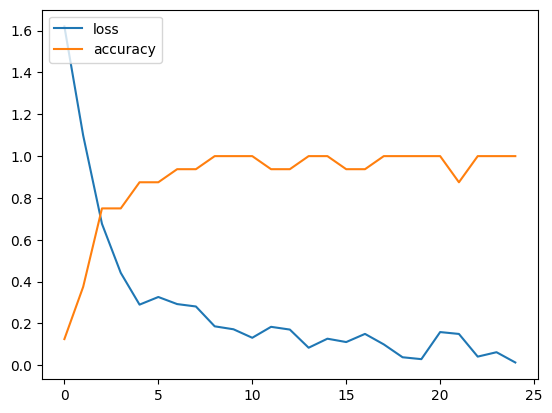

In [9]:
plt.plot(train_losses, label = "loss")
plt.plot(train_accuracies, label = "accuracy")
plt.legend(loc="upper left")

plt.show()

In [10]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [11]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

Predicted: Jens_Stoltenberg Actual: Jens_Stoltenberg


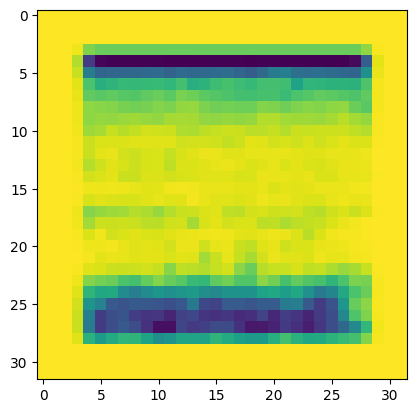

In [34]:
index = torch.randint(len(test_data), ()).item()

X, y = test_data[index]

X = X[None, :]

imgplot = plt.imshow(X[0][0])

model.eval()
with torch.no_grad():
    X = X.to(device)
    pred = model(X)

class_index = torch.squeeze(torch.argmax(pred, dim=1)).item()

print(
    f"Predicted: {test_data.dataset.classes[class_index]} Actual: {test_data.dataset.classes[y]}"
)

In [35]:
X.shape

model(X)

tensor([[ 12.0959,  -2.5139,  -0.6055,  -9.7255, -10.1560]],
       grad_fn=<AddmmBackward0>)

In [19]:
test_data.dataset.class_to_idx

In [24]:
print(test_data.dataset.class_to_idx)

{'Jens_Stoltenberg': 0, 'Benjamin_Netanyau': 1, 'Julia_Gillard': 2, 'Magaret_Tarcher': 3, 'Nelson_Mandela': 4}


In [37]:
X[0][0].shape

torch.Size([32, 32])